In [1]:
# Import the libraries
import pandas as pd
import zipfile
import re
import html 
import numpy as np
import folium
from folium.plugins import MarkerCluster
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abfs386\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#Import datasets
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/calendar.csv.zip") # having calendar.csv zipped file.
df_calanderS = pd.read_csv(zf.open("calendar.csv"))
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/calendar.csv (1).zip") # having calendar.csv zipped file.
df_calanderB = pd.read_csv(zf.open("calendar.csv"))
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/listings.csv.zip") # having calendar.csv zipped file.
df_listingsS = pd.read_csv(zf.open("listings.csv"))
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/listings.csv (1).zip") # having calendar.csv zipped file.
df_listingsB = pd.read_csv(zf.open("listings.csv"))
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/reviews.csv.zip") # having calendar.csv zipped file.
df_reviewsS = pd.read_csv(zf.open("reviews.csv"))
zf = zipfile.ZipFile(r"C:\Private\Fred - ABSA\Data Science Nanodegree\Term2\NanoDegree Project1 Term2/reviews.csv (1).zip") # having calendar.csv zipped file.
df_reviewsB = pd.read_csv(zf.open("reviews.csv"))

In [3]:
# Shape the datasets to see what the size is 
df_calanderS.shape, df_calanderB.shape, df_listingsS.shape, df_listingsB.shape, df_reviewsS.shape, df_reviewsB.shape

((1393570, 4), (1308890, 4), (3818, 92), (3585, 95), (84849, 6), (68275, 6))

In [4]:
df_reviewsS.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [5]:
# Merge the review data to listings data to get all the reviews for the listings  
df_Seattle = df_reviewsS.merge(df_listingsS, left_on = 'listing_id', right_on = 'id', how = 'left')
df_Boston = df_reviewsB.merge(df_listingsB, left_on = 'listing_id', right_on = 'id', how = 'left')

In [6]:
df_Seattle.shape

(84849, 98)

In [7]:
df_Boston.shape

(68275, 101)

In [8]:
# Create an indicator for the cities for later checks
df_Seattle['CityIndicator'] = 'Seattle'
df_Boston['CityIndicator'] = 'Boston'

In [9]:
# Drop the columns that is not needed and this is to append the datasets
dropcols = list(set(df_Boston.columns) - set(df_Seattle.columns))
print(dropcols)
df_Boston = df_Boston.drop(dropcols, axis = 1)

['interaction', 'house_rules', 'access']


In [10]:
# Final dataset 
df_Final = df_Seattle.append(df_Boston[df_Seattle.columns], ignore_index = True)

In [11]:
sum(df_Final.latitude.isnull() == True) & sum(df_Final.longitude.isnull() == True)

0

In [12]:
df_Final.price = df_Final.price.str.replace('$','')
df_Final.price = df_Final.price.str.replace(',','').astype(float)

In [13]:
attraction_listS = [['Pike Place Market', 47.6084, -122.3405], 
 ['Space Needle', 47.6205, -122.3493], 
 ['Olympic Sculpture Park', 47.6166, -122.3553],
 ['Washington State Ferries', 47.602722, -122.338512],
 ['Museum of History & Industry', 47.6276, -122.3366],
 ['Downtown waterfront', 47.6094, -122.3422],
 ['Seattle Art Museum', 47.6073, -122.3381],
 ['Chinatown International District', 47.5987, -122.3240],
 ['Ballard Locks', 47.6655, -122.3972],
 ['Seattle Aquarium', 47.6074,-122.3430]]

df_attractionsS = pd.DataFrame(data = attraction_listS, columns = ['attraction','longitude','latitude'])
# df_attractions.head()
attraction_listB = [['Freedom Trail', 42.3560, -71.0541], 
 ['Fenway Park', 42.3467, -71.0972], 
 ['Boston Theater District', 42.3519, -71.0643],
 ['Tea Party Ships & Museum', 42.3522, -71.0513],
 ['Museum of Fine Arts', 42.3394, -71.0940],
 ['Public Garden, Make Way for Ducklings, & Swan Boats', 42.3542,-71.0704],
 ['New England Aquarium', 42.3591, -71.0498],
 ['Beacon Hill', 42.3588, -71.0707],
 ['Newbury Street', 42.3481, -71.0879],
 ['Harvard', 42.3770, -71.1167]]

df_attractionsB = pd.DataFrame(data = attraction_listB, columns = ['attraction','longitude','latitude'])
# df_attractions.head()

In [14]:
def mapplot(data, Coordinates, City, attractionList, zoom):
    m = folium.Map(location=Coordinates, zoom_start=zoom)
    marker_cluster = MarkerCluster().add_to(m)

    count_value = data[data.CityIndicator == City].groupby('neighbourhood').agg({'listing_id':'count','price':'mean'}).reset_index()
    unique_prop = data[data.CityIndicator == City].drop_duplicates(subset = 'neighbourhood')
    unique_prop = unique_prop[['neighbourhood', 'longitude', 'latitude']].dropna(subset = {'neighbourhood'})
    unique_prop = unique_prop.merge(count_value, on = 'neighbourhood')

    for index, row in unique_prop.iterrows():
        html = """Neighbourhood: {0} <br>
                  Count: {1} <br>
                  Average Price: ${2}""".format(row[0], row[3], round(row[4],2))
        iframe = folium.IFrame(html=html,width=250, height=100)
        popup= folium.Popup(iframe, max_width=500)
        if row[4] > 125:
            colour = 'red'
        else:
            colour = 'blue'
        folium.Marker([row['latitude'], row['longitude']], popup = popup, icon=folium.Icon(color = colour)).add_to(m)

    for index, row in attractionList.iterrows():
        html = """{0}""".format(row[0])
        iframe = folium.IFrame(html=html,width=200, height=30)
        popup= folium.Popup(iframe, max_width=500)
        icon = folium.Icon(icon = 'tower', color = 'black')
        folium.Marker([row[1], row[2]], icon=icon, popup=popup).add_to(m)

    return(m)

In [15]:
# Seattle plot
m = mapplot(df_Final, (47.6050,-122.3344), 'Seattle', df_attractionsS, 11)
m

In [16]:
# Boston plot
m = mapplot(df_Final, (42.3601,-71.0589), 'Boston', df_attractionsB,11)
m

In [17]:
# Word cloud 
sum(df_Final.description.isnull() == True)

0

In [18]:
def wordcloud(data, city, stopwords):
    df_ = data[data.CityIndicator == city]
    df_ = df_.description
    wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black', stopwords = stopwords).generate(str(df_))
    fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

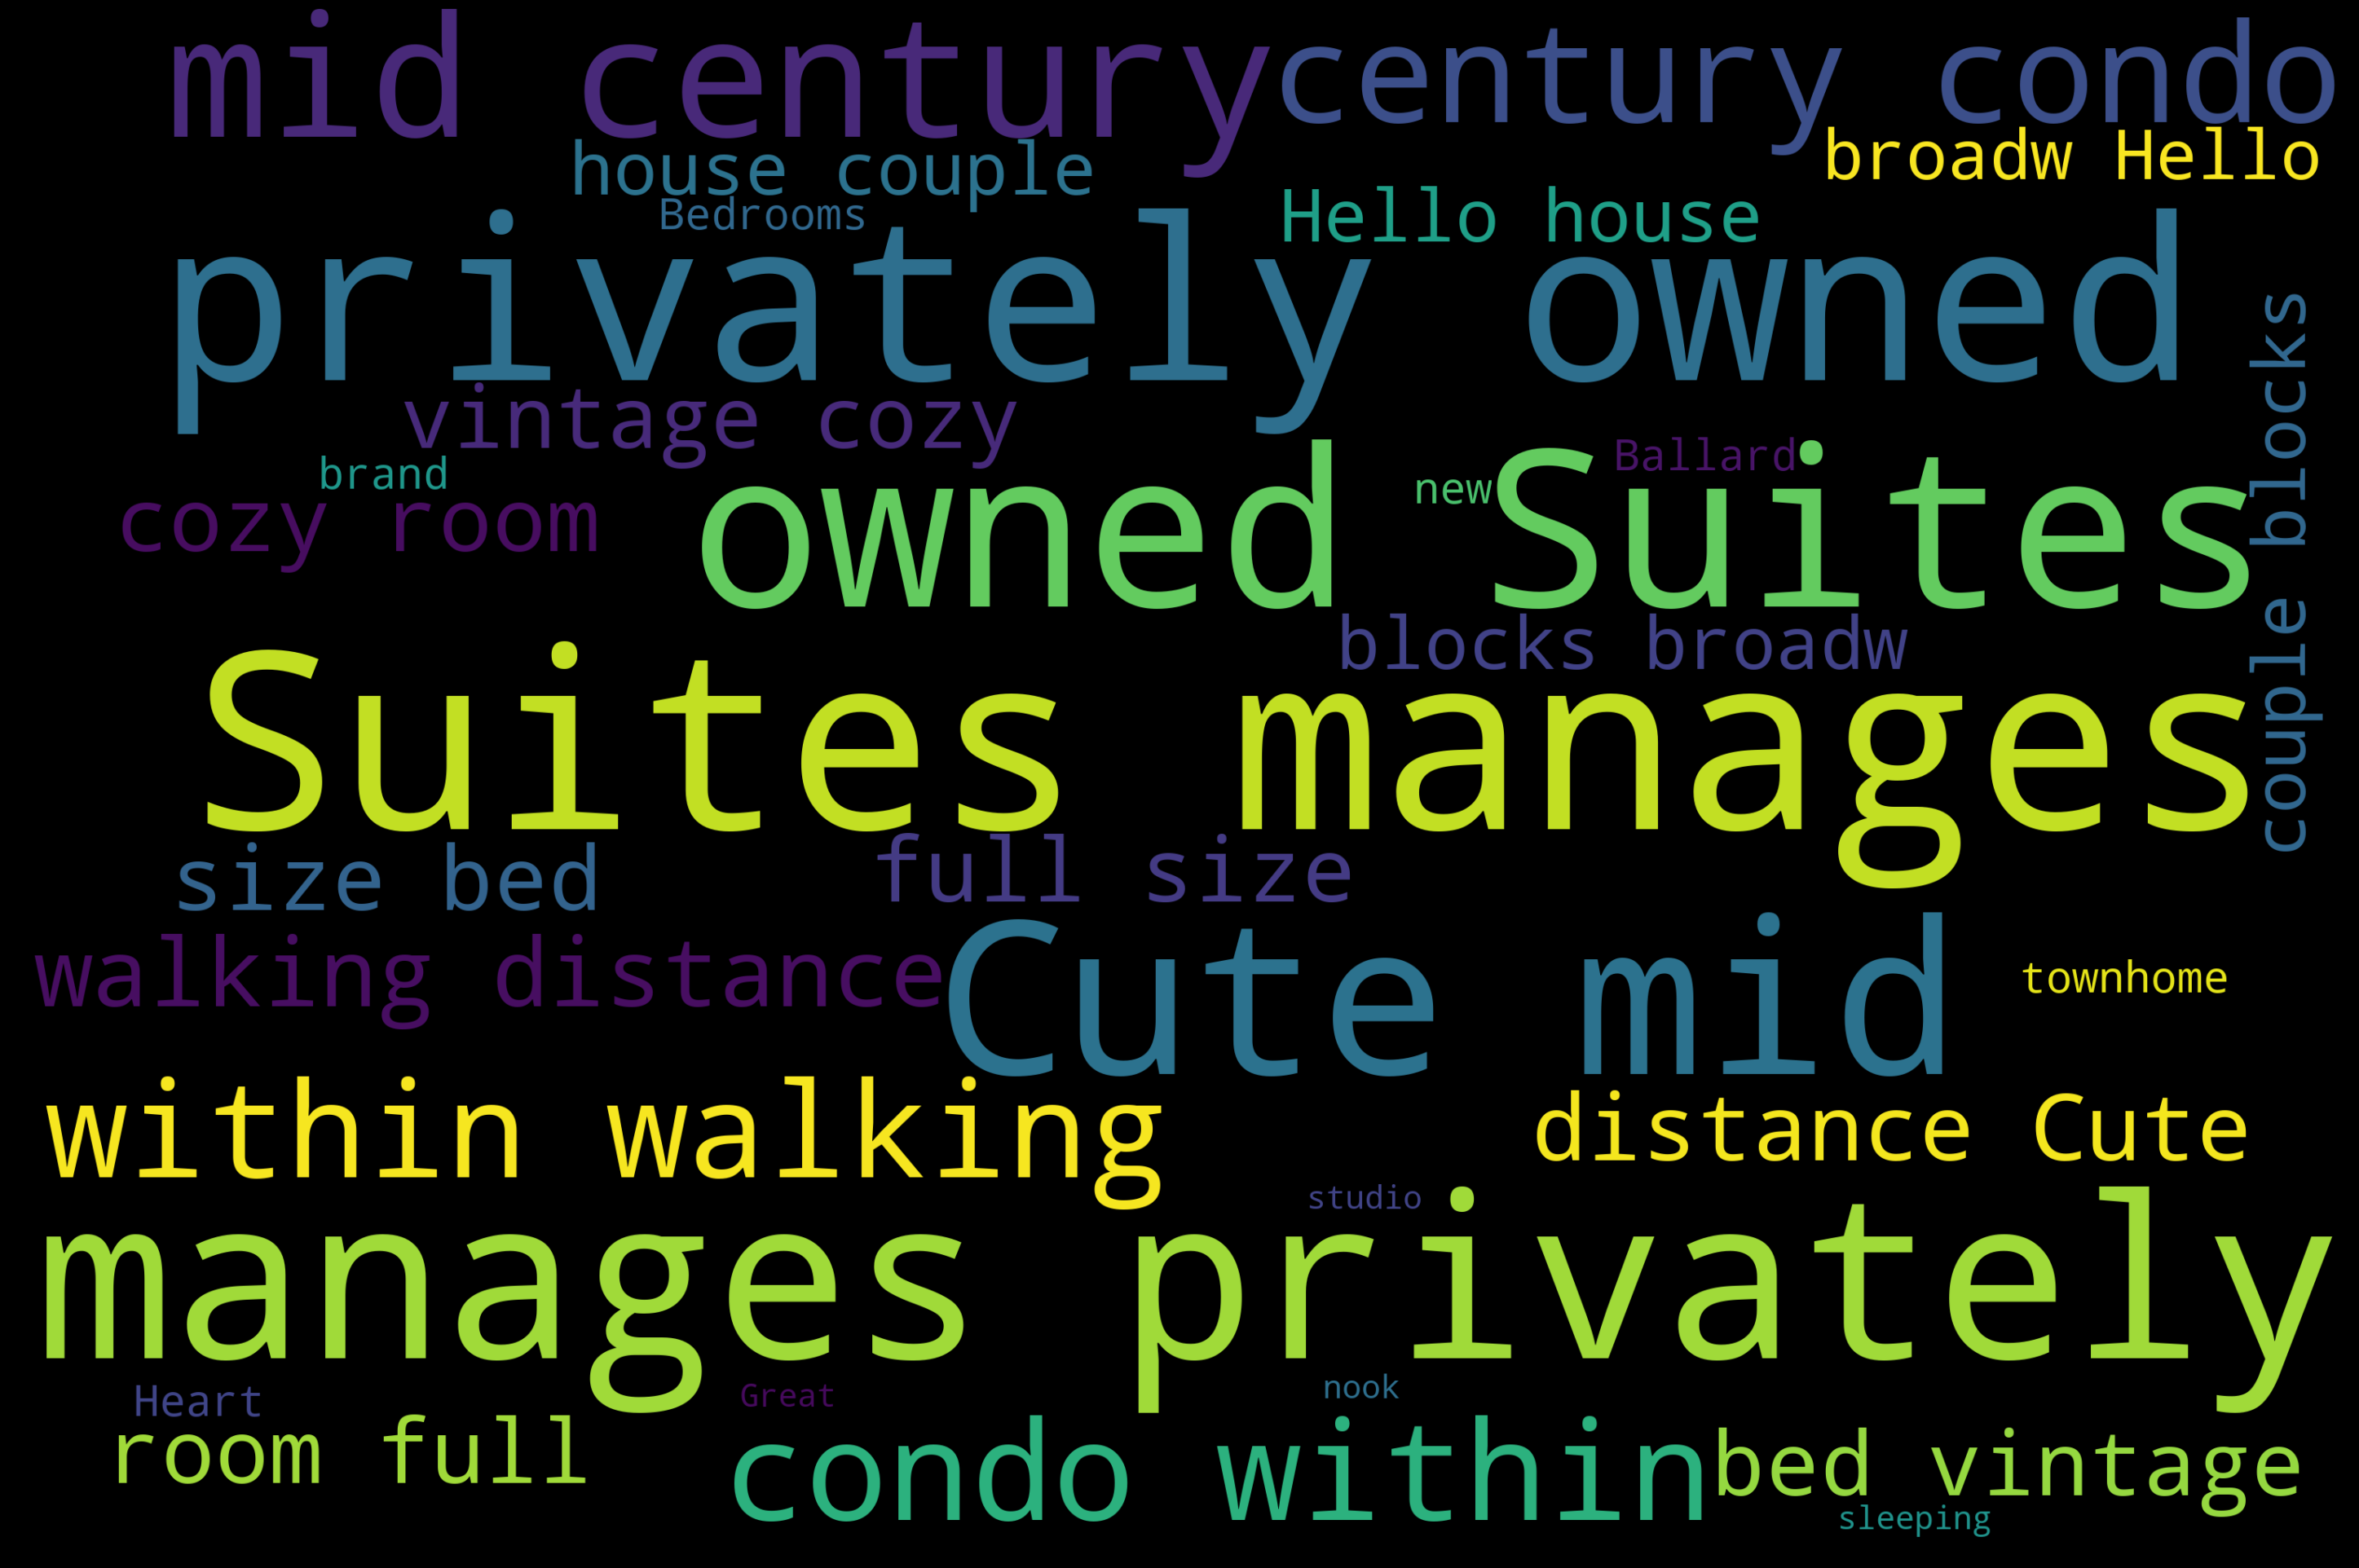

In [19]:
stopwords = set(STOPWORDS)
stopwords.update(['description', 'object', 'description', 'LLC', 'fu', 'Name', 'Length', 'Seattle', 'dtype'])

wordcloud(df_Final, 'Seattle', stopwords)

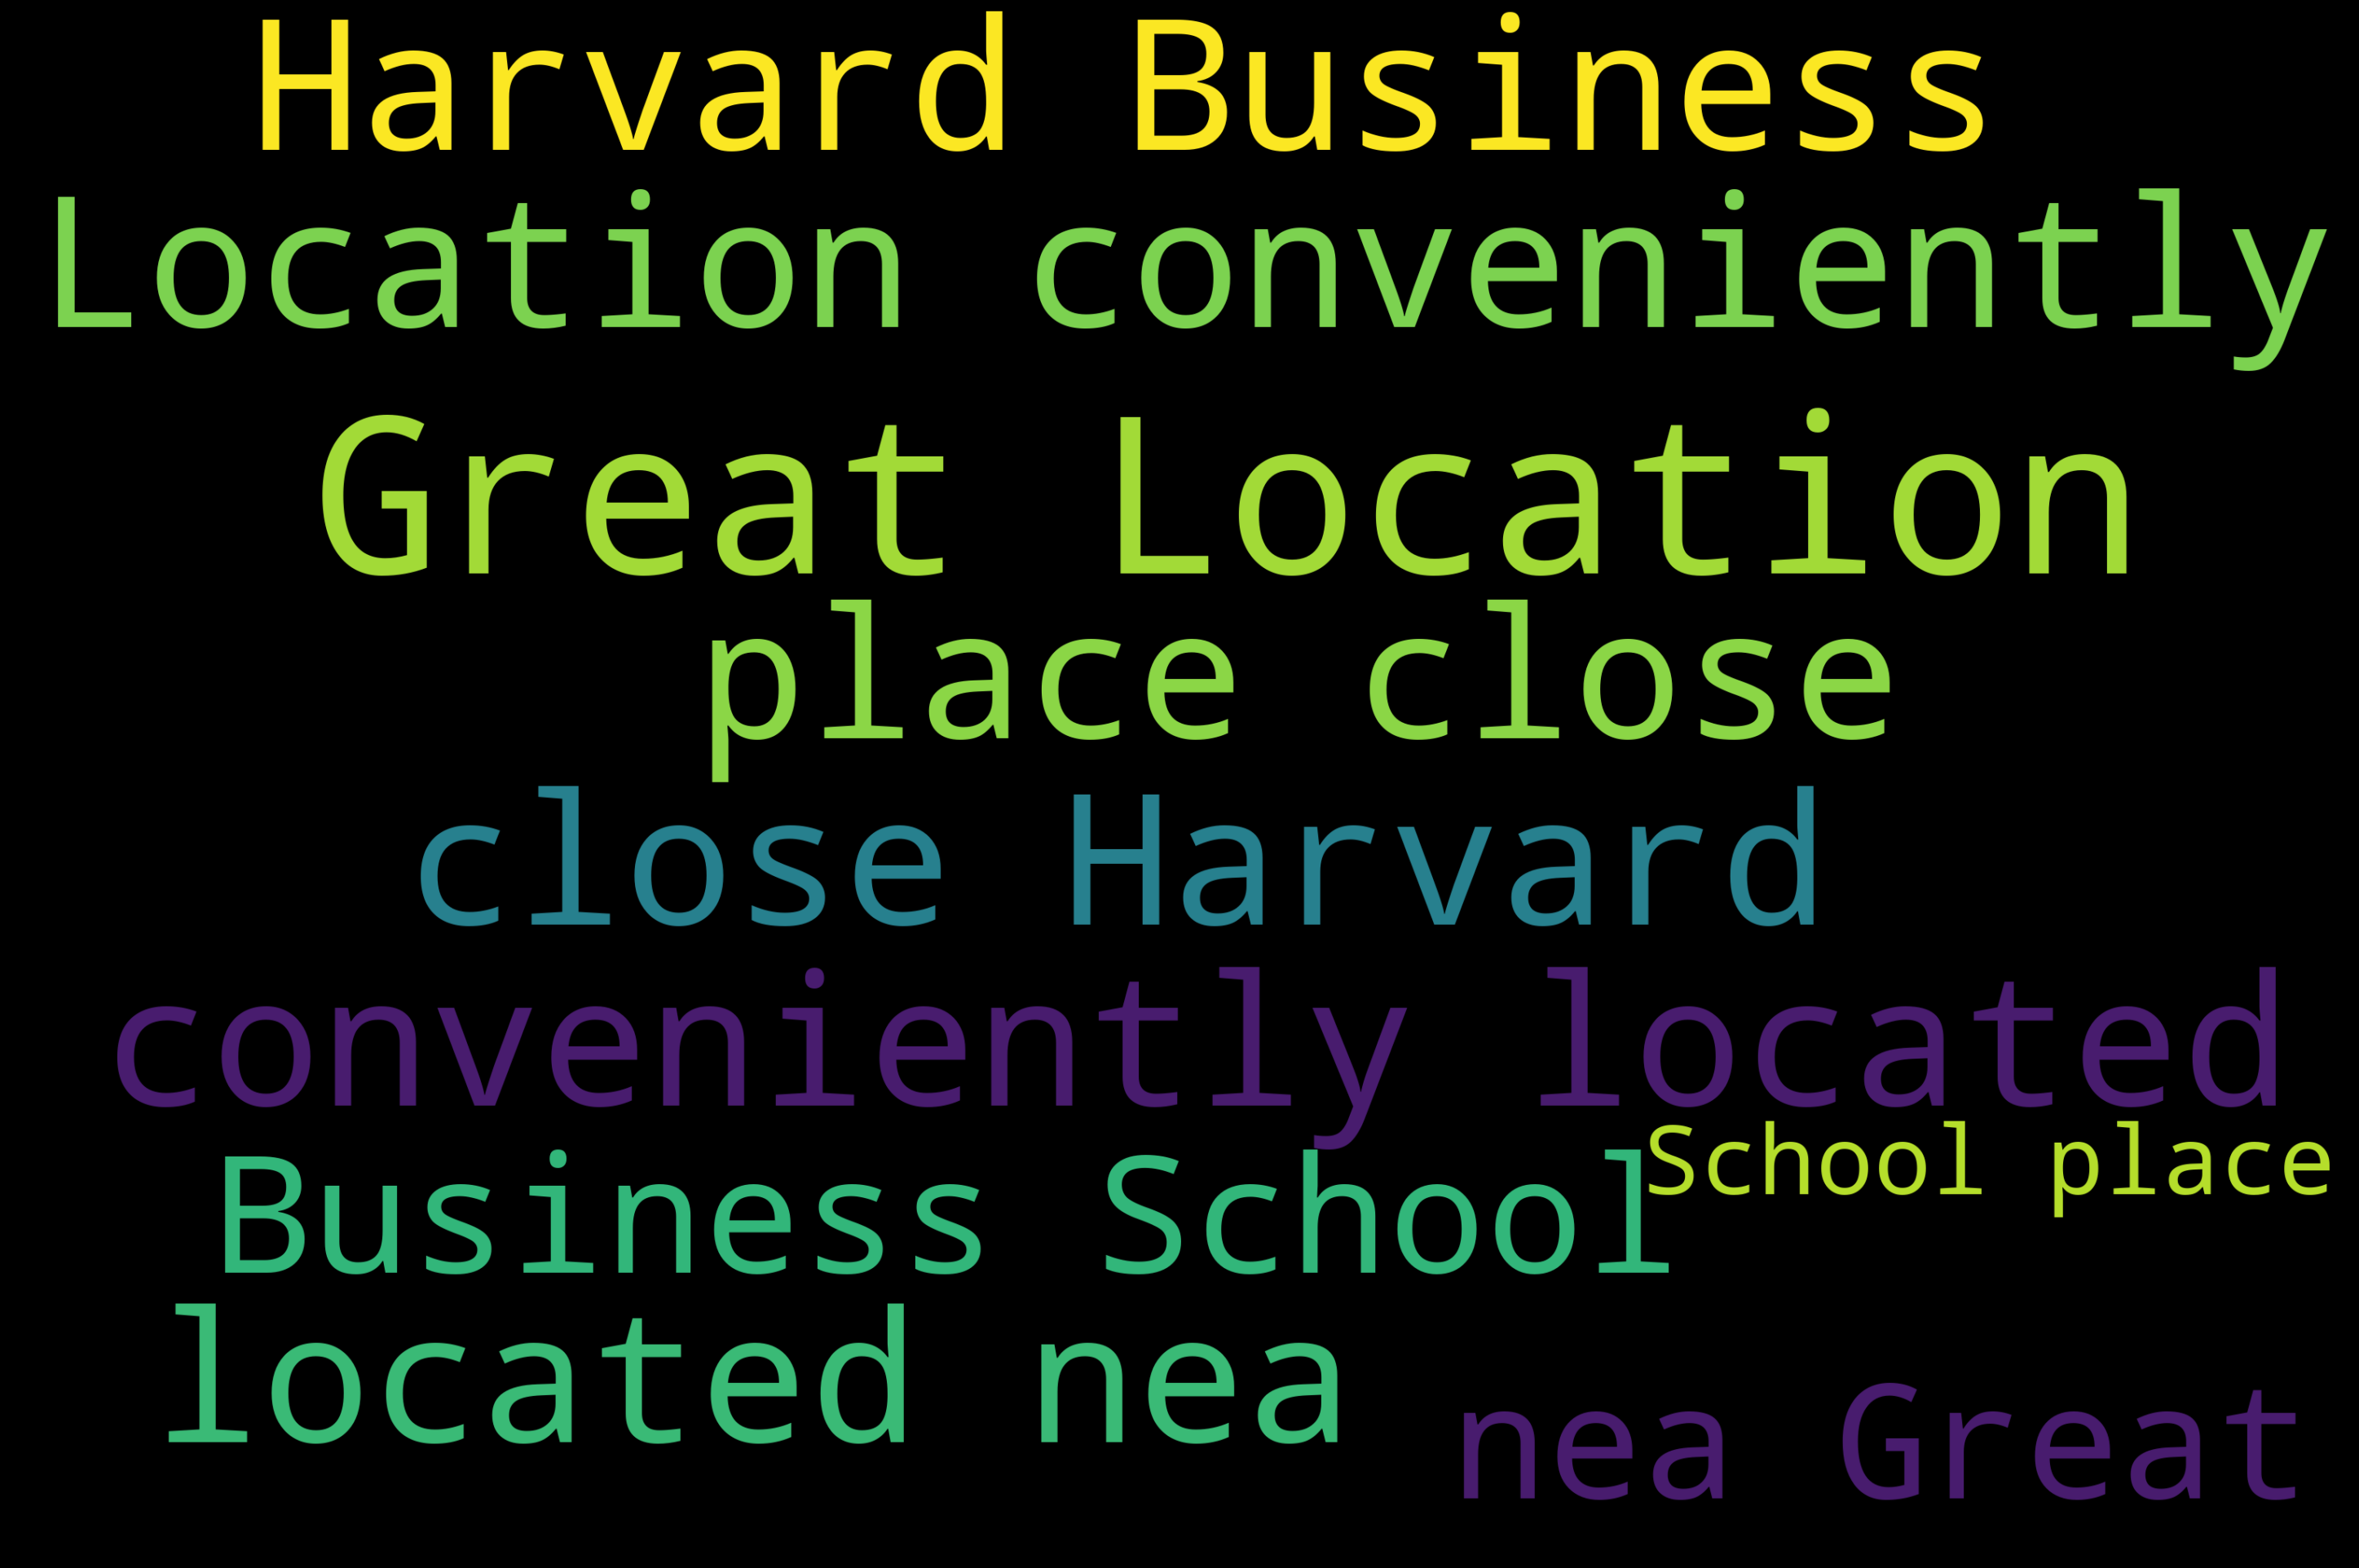

In [20]:
stopwords = set(STOPWORDS)
stopwords.update(['description', 'object', 'description', 'LLC', 'fu', 'Name', 'Length', 'Boston', 'dtype'])

wordcloud(df_Final, 'Boston', stopwords)

In [21]:
# centiment analysis on comments
sum(df_Final.comments.isnull() == True)

71

In [22]:
df_Seattle_sa = df_Final[df_Final.CityIndicator == 'Seattle']
df_Seattle_sa = df_Seattle_sa.drop_duplicates('description')
# df_Seattle_sa = df_Seattle_sa.description.drop_duplicates()
# df_Seattle_sa.shape

In [23]:
df_Boston_sa = df_Final[df_Final.CityIndicator == 'Boston']
df_Boston_sa = df_Boston_sa.drop_duplicates('description')

In [24]:
def sentiment(data):
    sid = SentimentIntensityAnalyzer()
    sentiment_list_neg = []
    sentiment_list_neu = []
    sentiment_list_pos = []
    sentiment_list_com = []
    sentence_list = []
    for sentence in data.description:
        ss_s = sid.polarity_scores(sentence)
        sentence_list.append(sentence)
        sentiment_list_neg.append(ss_s.get('neg'))
        sentiment_list_neu.append(ss_s.get('neu'))
        sentiment_list_pos.append(ss_s.get('pos'))
        sentiment_list_com.append(ss_s.get('compound'))    
        
    data['Negative'] = sentiment_list_neg
    data['Neutral'] = sentiment_list_neu
    data['Positive'] = sentiment_list_pos
    data['Compound'] = sentiment_list_com
    
    return(data)
    
df_Seattle_sa = sentiment(df_Seattle_sa)
df_Boston_sa = sentiment(df_Boston_sa)

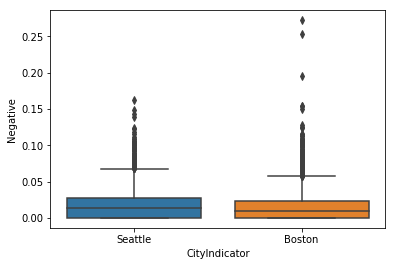

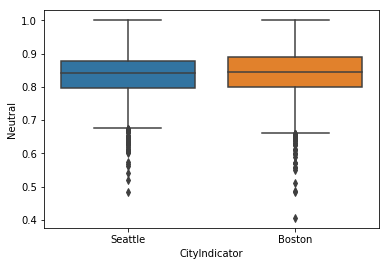

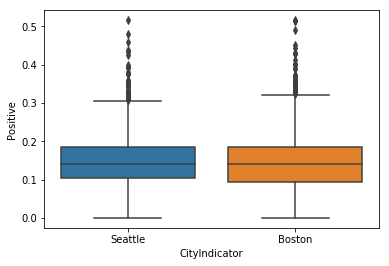

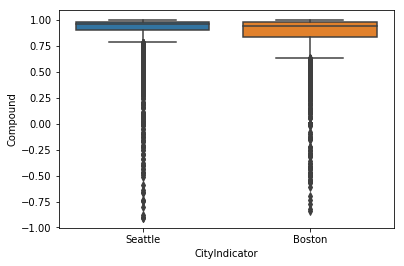

In [25]:
df_sentiment = df_Seattle_sa.append(df_Boston_sa)
for i in ['Negative', 'Neutral', 'Positive', 'Compound']:
    ax = sns.boxplot(x = df_sentiment.CityIndicator, y = df_sentiment[i])
    plt.show()